# Közlekedési hálózatok vizsgálata
## Szeged városi tömegközlekedés

TramTrain kivételével

In [1]:
import networkx as nx
import peartree as pt
import matplotlib.pyplot as plt
import osmnx as ox

### Szeged tömegközlekedései adatok beolvasása

In [2]:
### np.unicode is deprecated after version 1.20.0 and removed in 1.24.0
#import numpy as np
#
#np.unicode = np.unicode_

### pd.Seried.iteritems() is deprecated after version 1.5.0 and removed in 2.0
import pandas as pd

def iteritems(self):
  yield from self.items()
pd.Series.iteritems = iteritems

#path = './gtfs-1.zip' #összes
#path = './gtfs-11.zip' #bartók
path = './gtfs-0.zip' #centrum
feed = pt.get_representative_feed(path)

start = 7*60*60  # 7:00 AM
end = 10*60*60  # 10:00 AM

G = pt.load_feed_as_graph(feed, start, end)

### Szeged ábrázolása

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

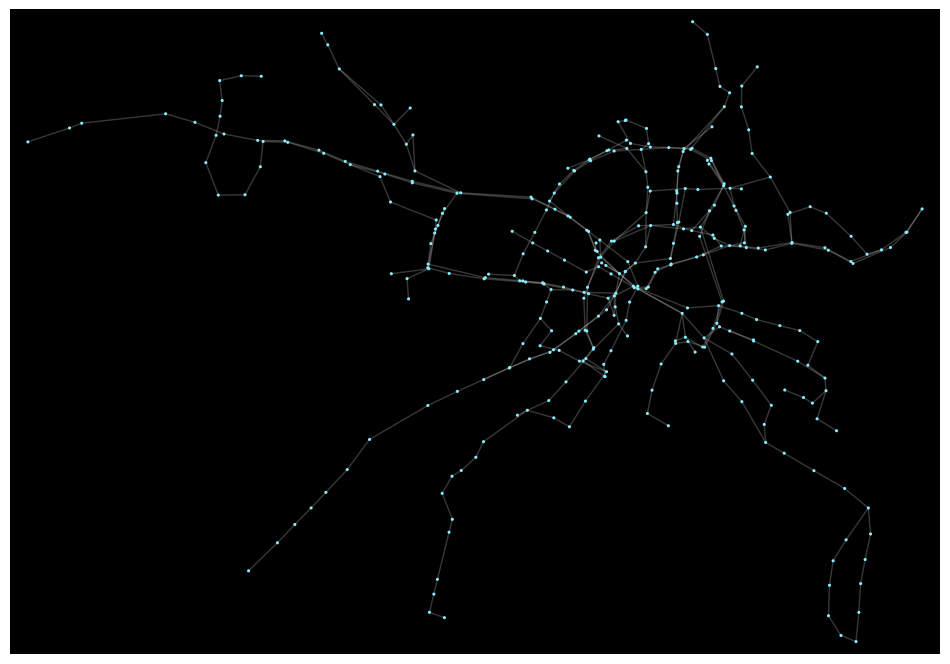

In [22]:
pt.plot.generate_plot(G)

### Edge betweenness ábrázolása

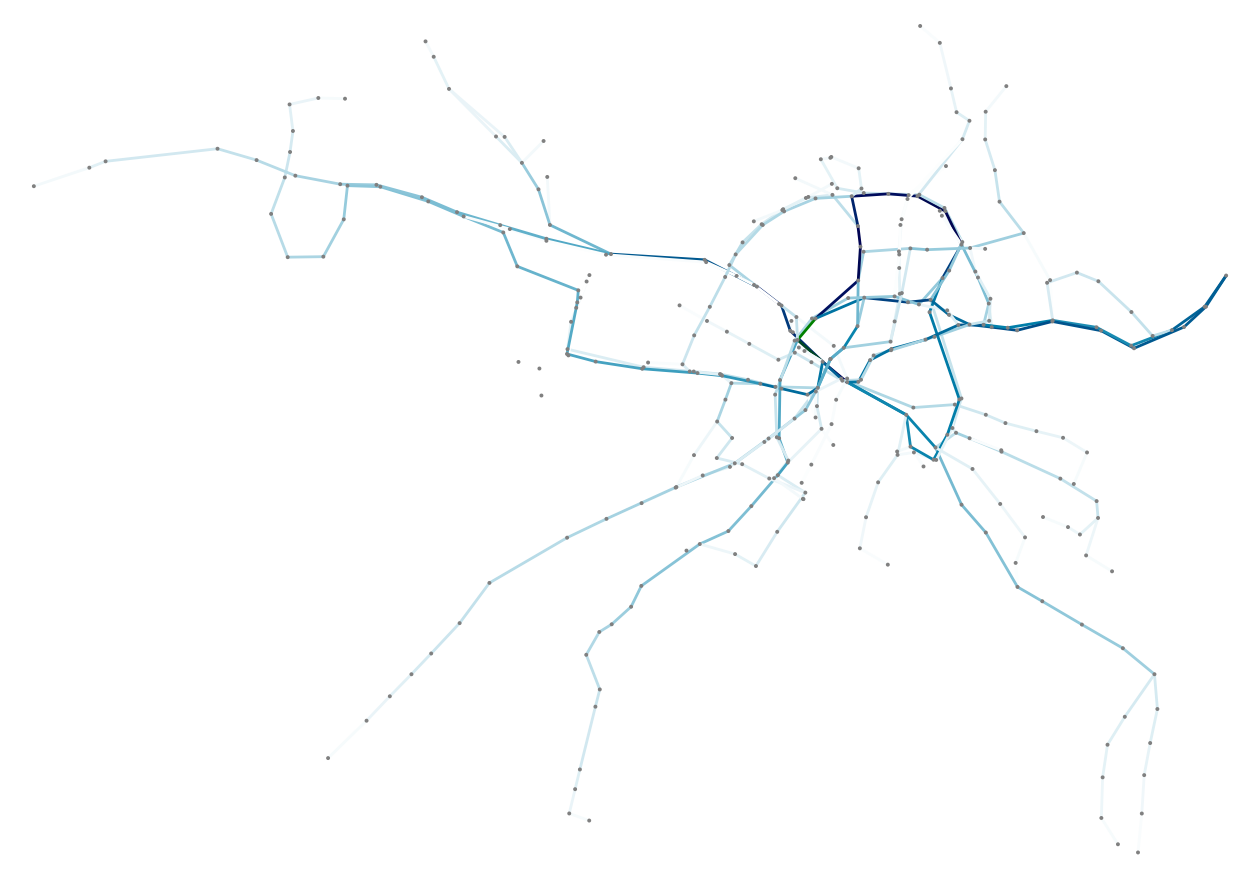

In [10]:
bc = nx.edge_betweenness_centrality(G)
nx.set_edge_attributes(G, bc, "weight")

ec = ox.plot.get_edge_colors_by_attr(G, "weight", cmap="ocean_r")

fig, ax = ox.plot_graph(
    G,
    node_color="gray",
    edge_color=ec,
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white"
)

Minél sötétebb egy él, annál nagyobb az edge betweenness értéke azaz a központisága.

### Gráf egyszerűsítése és edge betweenness

In [77]:
G_proj = ox.project_graph(G)
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=40, dead_ends=False)

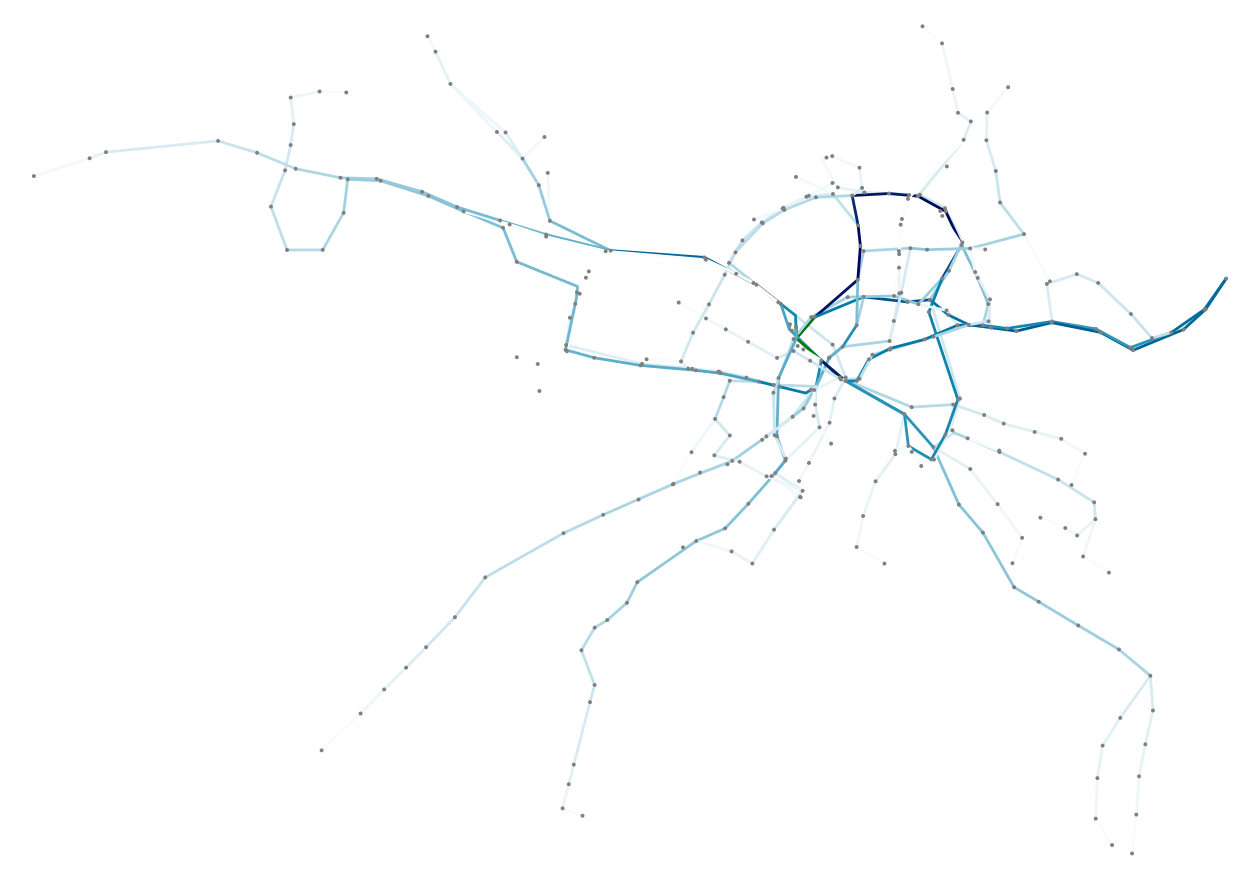

In [76]:
bc = nx.edge_betweenness_centrality(G2)
nx.set_edge_attributes(G2, bc, "weight")

ec = ox.plot.get_edge_colors_by_attr(G2, "weight", cmap="ocean_r")

fig, ax = ox.plot_graph(
    G2,
    node_color="gray",
    edge_color=ec,
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white"
)

### Minimális feszítőfa ábrázolása

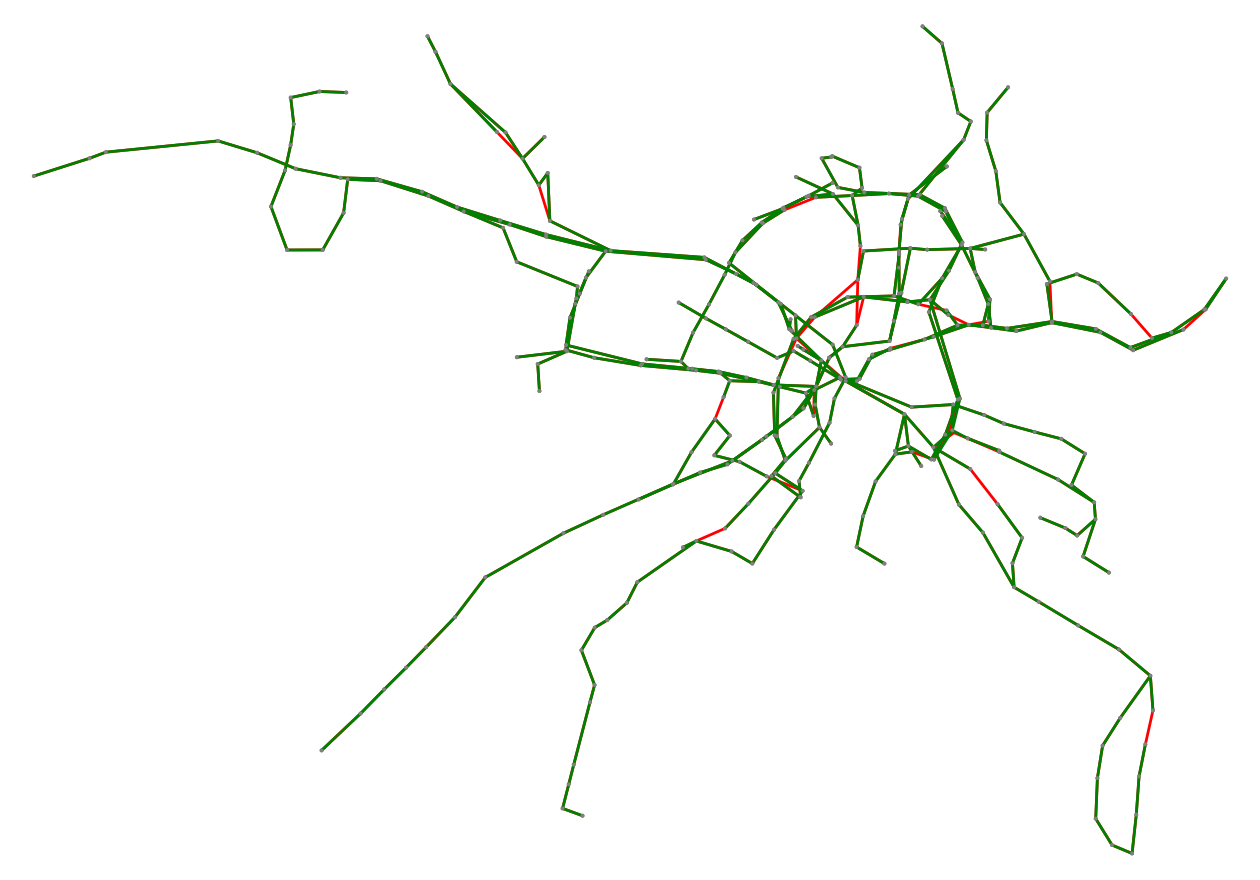

In [81]:
S = G2.to_undirected()
mst = nx.minimum_spanning_tree(S)

# Plot the original graph to serve as the base
fig, ax = ox.plot_graph(
    S,
    node_color="gray",
    edge_color='red', 
    node_size=8,
    edge_linewidth=2,
    figsize=(16,16),
    dpi=100,
    bgcolor="white", 
    show=False
)


# Plot the spanning tree edges with a different color
ox.plot_graph(ox.project_graph(mst),
    node_color="gray", edge_color='green', node_size=8,
    edge_linewidth=2,
    figsize=(16,16), dpi=100,
    bgcolor="white",
    ax=ax,
    show=False
)

# Show the plot
plt.show()

In [ ]:
import nbimporter
import functions as func

#func.ust_matrix(G, 2)

tree = nx.random_spanning_tree(S, None)

edges_to_color = [(u, v) for u, v, data in S.edges(data=True) if (u, v) in tree.edges(data=True)]
edge_colors = ['orange' if (u, v) in edges_to_color else 'k' for u, v in S.edges()]